# 1.准备工作

## 1.1 设置参数

In [121]:
%matplotlib inline
import os
import math
import time
import numpy as np
from PIL import Image
from scipy import misc
import SimpleITK as sitk
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier 
from sklearn.feature_extraction.image import reconstruct_from_patches_2d
from sklearn.feature_extraction.image import extract_patches as sk_extract_patches
num_classes = 3
layer=28 #要分割第几层

test_path = 'datasets/testdata'
train_path = 'datasets/traindata'

patch_shape=(5,7,7)
patch_shape1=(19,19)

r=int(patch_shape[0]/2) #用到几层图像
pr=int(patch_shape[1]/2)
rr1=int(3/2) #第二层取3层原图 和 3张概率图
extraction_step0=(3,1,1)
extraction_step1=(1,1)

## 1.2 自定义函数

In [2]:
def get_mask(GT, values, label):
        if type(values) == int:
            values = [values]
        mask = np.zeros(GT.shape)
        for i in range(len(values)):
            mask += (GT == values[i]) * label
        return mask
    
def read_vol(path,n):
    path=os.path.join(path,n)
    itk_img=sitk.ReadImage(path)
    data=sitk.GetArrayFromImage(itk_img)
    return data

def extract_patches(volume, patch_shape, extraction_step) :
    patches = sk_extract_patches(
        volume,
        patch_shape=patch_shape,
        extraction_step=extraction_step) 
    #patches.shape(3,54,54,27,27) 3:1+(50-27)/9,54:1+(512-27)/9
    ndim = len(volume.shape) #dim=3
    npatches = np.prod(patches.shape[:ndim]) #multiply each number
    return patches.reshape((npatches, ) + patch_shape)

#### 制作原图像的数据集

In [3]:
def build_set(T2_vols, label_vols, patch_shape, extraction_step=(9, 9, 9)) :
    r1=int(patch_shape[0]/2)
    r2=int(patch_shape[1]/2)
    r3=int(patch_shape[2]/2)
    label_selector = [slice(None)] + [slice(r1,r1+1)]+[slice(r2, r2+1)]+[slice(r3,r3+1)]
    x = np.zeros((0, patch_shape[0],patch_shape[1],patch_shape[2]))
    y = np.zeros((0, 1))
    for idx in range(len(T2_vols)) : #6
        y_length = len(y) #0

        label_patches = extract_patches(label_vols[idx], patch_shape, extraction_step)#（8748，7,7,7）
        totalpatch = label_patches[label_selector] #(8748,1,1,1)

        valid_idxs = np.where(totalpatch[:,0,0,0]!= 0) 
        label_patches = totalpatch[valid_idxs] #(2614,1,1,1)

        x = np.vstack((x, np.zeros((len(label_patches),patch_shape[0],patch_shape[1],patch_shape[2]))))
        y = np.vstack((y, np.zeros((len(label_patches),1))))

        for i in range(len(label_patches)) :
            y[i+y_length, :]=label_patches[i,0,0,0]
        del label_patches
        
        T2_train = extract_patches(T2_vols[idx], patch_shape, extraction_step)
        x[y_length:,:, :, :] = T2_train[valid_idxs]
        del T2_train
        
    return x, y,valid_idxs,totalpatch

In [131]:
def build_prob_set(prob_vols, label_vols, patch_shape1,extraction_step1=(9, 9)): 
    #输入 prob_vols:(6,5+3,512,512)
    #    label_vols:(6,1,512,512)
    r1=int(patch_shape1[0]/2)
    r2=int(patch_shape1[1]/2)
    label_selector = [slice(None)]+[slice(None)]+[slice(r1,r1+1)]+[slice(r2, r2+1)]
    new_z=3+rr1*2+1
    
    x = np.zeros((0, new_z, patch_shape1[0],patch_shape1[1]))
    y = np.zeros((0, 1))
    for idx in range(len(prob_vols)):
        y_length=len(y)
        
        label_patches = extract_patches(label_vols[idx], ((1,)+patch_shape1),((1,)+extraction_step1))
        totalpatch = label_patches[label_selector]
        valid_idxs = np.where(totalpatch[:,0,0,0]!= 0) 
        label_patches = totalpatch[valid_idxs]
        
        x = np.vstack((x, np.zeros((len(label_patches),new_z,patch_shape1[0],patch_shape1[1]))))
        y = np.vstack((y, np.zeros((len(label_patches),1))))
        
        for i in range(len(label_patches)) :
            y[i+y_length, :]=label_patches[i,0,0,0]
        del label_patches
        
        prob_train=extract_patches(prob_vols[idx],((new_z,)+patch_shape1),((new_z,)+extraction_step1))
        x[y_length:,:, :, :] = prob_train[valid_idxs]
        del prob_train
        
    return x,y,valid_idxs,totalpatch

#### 制作原图像+图谱图像的数据集

In [133]:
def build_set_with_prob(T2_vols,label_vols,layer,rf,patch_shape1,extraction_step1):#patch_shape=[1,n,n]
#     输入：T2_vols:(6,50,5)
    x= np.zeros((0, np.prod(patch_shape1)))
    y= np.zeros((0, 1))
    new_vol=np.zeros((len(T2_vols),3+rr1*2+1,512,512))
    new_label=np.zeros((len(T2_vols),1,512,512))
    for n in range(len(T2_vols)):
        
        label_v=label_vols[:,layer-r:layer+r+1]
        T2_v=T2_vols[:,layer-r:layer+r+1]
        
        t2=np.zeros((1,T2_v.shape[1],T2_v.shape[2],T2_v.shape[3]))
        l=np.zeros((1,T2_v.shape[1],T2_v.shape[2],T2_v.shape[3]))
        t2[0]=T2_v[n]
        l[0]=label_v[n]

        x_test,ground_true,index,fullpatch=build_set(t2,l,patch_shape,(3,1,1))
        x_test=x_test.reshape((x_test.shape[0],np.prod(patch_shape)))

        test_res=rf.predict(x_test) #need to reshape
        test_res=test_res.reshape(test_res.shape[0],1)

        c=rf0.predict_proba(x_test)

        # 求训练个体的概率图
        height=int(math.sqrt(fullpatch.shape[0]))

        gm=c[:,0]
        gm=gm.reshape((len(gm),1))
        probgm=np.zeros((fullpatch.shape[0],1,1))
        probgm[:,0,0]=fullpatch[:,0,0,0]
        probgm[index,0,0]=gm[:,0]
        gm=reconstruct_from_patches_2d(probgm,(height,height)) 

        wm=c[:,1]
        wm=wm.reshape((len(wm),1))
        probwm=np.zeros((fullpatch.shape[0],1,1))
        probwm[:,0,0]=fullpatch[:,0,0,0]
        probwm[index,0,0]=wm[:,0]
        wm=reconstruct_from_patches_2d(probwm,(height,height)) 

        csf=c[:,2]
        csf=csf.reshape((len(csf),1))
        probcsf=np.zeros((fullpatch.shape[0],1,1))
        probcsf[:,0,0]=fullpatch[:,0,0,0]
        probcsf[index,0,0]=csf[:,0]
        csf=reconstruct_from_patches_2d(probcsf,(height,height)) 

        gm_mask=np.zeros((512,512))
        wm_mask=np.zeros((512,512))
        csf_mask=np.zeros((512,512))
        gm_mask[pr:512-pr,pr:512-pr]=gm
        wm_mask[pr:512-pr,pr:512-pr]=wm
        csf_mask[pr:512-pr,pr:512-pr]=csf
        
        new_vol[n,0:1+rr1*2]=T2_vols[n,layer-rr1:layer+rr1+1]
        new_vol[n,1+rr1*2]=gm_mask
        new_vol[n,1+1+rr1*2]=wm_mask
        new_vol[n,2+1+rr1*2]=csf_mask
        
    new_mean = new_vol.mean()
    new_std = new_vol.std()
    new_vol = (new_vol - new_mean) / new_std
    new_label[:,0]=label_vols[:,layer]
    
    x,y,index,fullpatch=build_prob_set(new_vol,new_label,patch_shape1,extraction_step1)
    
    return x,y,index,fullpatch

#### 调整数据分布

In [78]:
def sufful_data(x_train,y_train,ground_true):
    gm_tr=np.sum(y_train[:,0]==1)
    wm_tr=np.sum(y_train[:,0]==2)
    csf_tr=np.sum(y_train[:,0]==3)

    gm_gt=np.sum(ground_true[:,0]==1)
    wm_gt=np.sum(ground_true[:,0]==2)
    csf_gt=np.sum(ground_true[:,0]==3)

    #由于训练样本不同类的数量不一样，找到一个基准，将所有类调成GT的分布
    p1=gm_tr/gm_gt
    p2=wm_tr/wm_gt
    p3=csf_tr/csf_gt
    p=[p1,p2,p3]
    max_class=p.index(min(p))

    # 正常该有的分布 根据ground true确定 
    total=ground_true.shape[0] 
    gm=np.sum(ground_true[:,0]==1)
    wm=np.sum(ground_true[:,0]==2)
    csf=np.sum(ground_true[:,0]==3)

    gm_percentage=gm/total
    wm_percentage=wm/total
    csf_percentage=csf/total

    percetange=[gm_percentage,wm_percentage,csf_percentage]
    percetange=percetange/percetange[max_class]

    train_number=percetange*[gm_tr,wm_tr,csf_tr]
    train_number=np.array(train_number,dtype='int') 

    #求出训练样本各个类的索引位置
    gm_tr_index=np.where(y_train[:,0]==1)
    wm_tr_index=np.where(y_train[:,0]==2)
    csf_tr_index=np.where(y_train[:,0]==3)
    gm_tr_index=np.array(gm_tr_index).T
    wm_tr_index=np.array(wm_tr_index).T
    csf_tr_index=np.array(csf_tr_index).T

    #打乱样本编号
    #要丢弃对样本编号
    drop_gm_idx=shuffle(gm_tr_index)[:len(gm_tr_index)-train_number[0]]
    drop_wm_idx=shuffle(wm_tr_index)[:len(wm_tr_index)-train_number[1]]
    drop_csf_idx=shuffle(csf_tr_index)[:len(csf_tr_index)-train_number[2]] #(....,1)

    #合并要丢弃对样本
    drop_num=np.vstack((drop_gm_idx,drop_wm_idx,drop_csf_idx))
    #转换类型
    drop_idx=drop_num.reshape((drop_num.shape[0]))

    xt=np.delete(x_train,drop_idx,axis=0)
    yt=np.delete(y_train,drop_idx,axis=0)
    return xt,yt

In [5]:
def dice(gt,testlabel): #(2341,1)
    a=np.sum(gt[:,0]==1)
    b=np.sum(testlabel[:,0]==1)
    m1g=np.where(gt[:,0]==1,1,0)
    m1l=np.where(testlabel[:,0]==1,1,0)
    m1=m1g+m1l
    c1=np.sum(m1==2)
    dice_gm=c1*2/(a+b)
    
    a=np.sum(gt[:,0]==2)
    b=np.sum(testlabel[:,0]==2)
    m2g=np.where(gt[:,0]==2,1,0)
    m2l=np.where(testlabel[:,0]==2,1,0)
    m2=m2g+m2l
    c2=np.sum(m2==2)
    dice_wm=c2*2/(a+b)
    
    a=np.sum(gt[:,0]==3)
    b=np.sum(testlabel[:,0]==3)
    m3g=np.where(gt[:,0]==3,1,0)
    m3l=np.where(testlabel[:,0]==3,1,0)
    m3=m3g+m3l
    c3=np.sum(m3==2)
    dice_csf=c3*2/(a+b)
    
    total=np.sum(gt)
    dice_total=(c1*2+c2*2+c3*2)/total
    return dice_gm,dice_wm,dice_csf,dice_total

## 1.3 读数据

### (1) 训练图像

In [6]:
T2_vols = np.empty((6, 50, 512, 512))
label_vols = np.empty((6, 50, 512, 512))
name=os.listdir(train_path)
idx=0
for n in name:
    picname=n.split('.')[0]
    if(picname.split('_')[-1]=='seg'):
        continue  
    segname=picname.split('_')[0]+'_seg.mha'
    label_vols[idx]=read_vol(train_path,segname)
    T2_vols[idx] = read_vol(train_path,n)
    idx+=1

CSF_mask = get_mask(label_vols, values=[5,6], label=3)
GM_mask = get_mask(label_vols, values=[1,7,8], label=1)
WM_mask = get_mask(label_vols, values=[2], label=2)
label_vols = CSF_mask + GM_mask + WM_mask  

T2_mean = T2_vols.mean()
T2_std = T2_vols.std()
T2_vols = (T2_vols - T2_mean) / T2_std

In [33]:
label_v=label_vols[:,layer-r:layer+r+1]
T2_v=T2_vols[:,layer-r:layer+r+1]
print(T2_v.shape)
print(T2_vols.shape)

(6, 5, 512, 512)
(6, 50, 512, 512)


### (2) 测试图像

In [7]:
T2_test = np.empty((1, 50, 512, 512))
ground_true = np.empty((1, 50, 512, 512))
name=os.listdir(test_path)
picname=name[0].split('_')[0]

gtname=picname+'_seg.mha'
testname=picname+'_t2.mha'

ground_true[0]=read_vol(test_path,gtname)
T2_test[0] = read_vol(test_path,testname)

CSF_mask = get_mask(ground_true, values=[5,6], label=3)
GM_mask = get_mask(ground_true, values=[1,7,8], label=1)
WM_mask = get_mask(ground_true, values=[2], label=2)
gt_mask = CSF_mask + GM_mask + WM_mask 

T2_mean = T2_test.mean()
T2_std = T2_test.std()
T2_test = (T2_test - T2_mean) / T2_std

In [16]:
ground_t=gt_mask[:,layer-r:layer+r+1]
T2_t=T2_test[:,layer-r:layer+r+1]

### (3) 制作第一层测试集

In [34]:
x_test,ground_true,index,fullpatch=build_set(T2_t,ground_t,patch_shape,(3,1,1))
x_test=x_test.reshape((x_test.shape[0],np.prod(patch_shape)))
print(x_test.shape,ground_true.shape)

(60531, 245) (60531, 1)


### (4) 制作第二层测试集

In [134]:
x_test1,ground_true1,index1,fullpatch1=build_set_with_prob(T2_test,gt_mask,layer,rf0,patch_shape1,extraction_step1)
x_test1=x_test1.reshape((x_test1.shape[0],np.prod(((3+rr1*2+1,)+patch_shape1))))
print(x_test1.shape)

(60531, 2166)


In [128]:
x_test1.shape

(60531, 5, 19, 19)

### (5) 制作第三层测试集

In [ ]:
x_test2,ground_true2,index2,fullpatch2=build_set_with_prob(T2_test,gt_mask,layer,rf1,patch_shape2,extraction_step2)
x_test2=x_test2.reshape((x_test2.shape[0],np.prod(((3+patch_shape[0],)+patch_shape2))))
print(x_test2.shape)

## ----------------------------------------------------------------------------------------------------------------

# 2. 训练

## 2.1 第一层训练

### (1) 制作训练集并调整分布

In [79]:
x_train,y_train,idx,repatch=build_set(T2_v,label_v,patch_shape,extraction_step0)
x_train=x_train.reshape((x_train.shape[0],np.prod(patch_shape)))
print(x_train.shape,y_train.shape)
xt0,yt0=sufful_data(x_train,y_train,ground_true)

(356618, 245) (356618, 1)


### (2) 第一层训练

In [36]:
start = time.clock()
rf0 = RandomForestClassifier(n_estimators=60)  
rf0.fit(xt0,yt0)
elapsed = (time.clock()- start)
print("Time used:",elapsed/60)

/Users/zhangweiting/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Time used: 4.6640585


## 2.2 第二层训练

### (1) 制作第二层训练集并调整分布

In [135]:
x_train,y_train,idx1,repatch1=build_set_with_prob(T2_vols,label_vols,layer,rf0,patch_shape1,extraction_step1)
x_train=x_train.reshape((x_train.shape[0],np.prod(((3+rr1*2+1,)+patch_shape1))))
print(x_train.shape,y_train.shape)
xt1,yt1=sufful_data(x_train,y_train,ground_true)

(356618, 2166) (356618, 1)


NameError: name 'ground_tound_true' is not defined

### (2) 第二层训练

In [137]:
start = time.clock()
rf1 = RandomForestClassifier(n_estimators=60)  
rf1.fit(xt1,yt1)
elapsed = (time.clock()- start)
print("Time used:",elapsed/60)

/Users/zhangweiting/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Time used: 7.558889849999999


## 2.3 第三层训练

### (1) 制作第三层训练集并调整分布

In [ ]:
x_train,y_train,idx2,repatch2=build_set_with_prob(T2_vols,label_vols,layer,rf1,patch_shape2,extraction_step2)
x_train=x_train.reshape((x_train.shape[0],np.prod(((3+patch_shape[0],)+patch_shape2))))
print(x_train.shape,y_train.shape)
xt2,yt2=sufful_data(x_train,y_train,ground_true)

### (2) 第三层训练

In [ ]:
start = time.clock()
rf2 = RandomForestClassifier(n_estimators=60)  
rf2.fit(xt2,yt2)
elapsed = (time.clock()- start)
print("Time used:",elapsed/60)

## ----------------------------------------------------------------------------------------------------------------

# 3. 测试

## 3.1 第一层输出

In [38]:
height=int(math.sqrt(fullpatch.shape[0]))
test_res0=rf0.predict(x_test) #need to reshape
test_res0=test_res0.reshape(test_res0.shape[0],1)
c0=rf0.predict_proba(x_test)

dice_gm,dice_wm,dice_csf,dice_total=dice(ground_true,test_res0)
print(dice_gm,dice_wm,dice_csf)
print(dice_total)

0.827241611912 0.89098754376 0.876656472987
0.920840602835


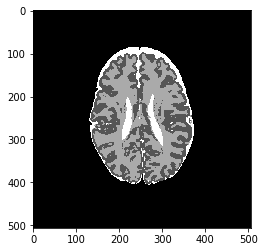

In [100]:
test=np.zeros((fullpatch.shape[0],1,1))
test[:,0,0]=fullpatch[:,0,0,0]
test[index,0,0]=test_res0[:,0]
test_0=reconstruct_from_patches_2d(test,(height,height)) 
plt.imshow(test_0,cmap='gray')

In [33]:
misc.imsave("L1-P5_7_7-Tree60.bmp",test_0)

## 3.2 第二层输出

In [138]:
height1=int(math.sqrt(fullpatch1.shape[0]))
test_res1=rf1.predict(x_test1) #need to reshape
test_res1=test_res1.reshape(test_res1.shape[0],1)
c1=rf1.predict_proba(x_test1)

dice_gm,dice_wm,dice_csf,dice_total=dice(ground_true1,test_res1)
print(dice_gm,dice_wm,dice_csf)
print(dice_total)

0.780655512262 0.847596655294 0.903426791277
0.884228614513


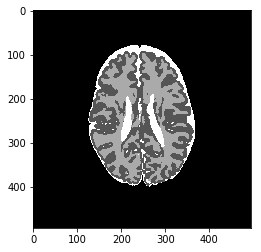

In [139]:
height1=int(math.sqrt(fullpatch1.shape[0]))
test=np.zeros((fullpatch1.shape[0],1,1))
test[:,0,0]=fullpatch1[:,0,0,0]
test[index1,0,0]=test_res1[:,0]
test_1=reconstruct_from_patches_2d(test,(height1,height1)) 
plt.imshow(test_1,cmap='gray')

In [140]:
misc.imsave("L2-P1(5,7,7)-P2(3,19,19)-Tree60.bmp",test_1)

## 3.3 第三层输出

In [37]:
test_res2=rf1.predict(x_test2) #need to reshape
test_res2=test_res2.reshape(test_res2.shape[0],1)
c2=rf2.predict_proba(x_test2)

dice_gm,dice_wm,dice_csf,dice_total=dice(ground_true2,test_res2)
print(dice_gm,dice_wm,dice_csf)
print(dice_total)

0.706787844362 0.836674067357 0.665753174386
0.815125240003


In [ ]:
height2=int(math.sqrt(fullpatch2.shape[0]))
test=np.zeros((fullpatch2.shape[0],1,1))
test[:,0,0]=fullpatch2[:,0,0,0]
test[index,0,0]=test_res2[:,0]
test_2=reconstruct_from_patches_2d(test,(height2,height2)) 
plt.imshow(test_2,cmap='gray')

In [ ]:
misc.imsave("L3-P5_7_7-Tree60.bmp",test_2)

# 4.测试原图和标签

## 4.1 金标准

In [81]:
fp=np.zeros((fullpatch.shape[0],1,1))
fp[:,0,0]=fullpatch[:,0,0,0]
GT=reconstruct_from_patches_2d(fp,(height,height)) 
plt.imshow(GT,cmap='gray')

(258064, 1, 1)


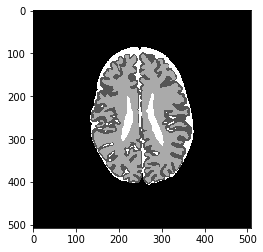

In [82]:
misc.imsave("GroundTrue.bmp",GT)

## 4.2 原图

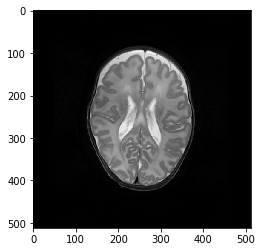

In [137]:
plt.imshow(T2_vols[0,28],cmap='gray')

### (3)GM Prob

In [55]:
gm=c[:,0]
gm=gm.reshape((len(gm),1))
probgm=np.zeros((fullpatch.shape[0],1,1))
probgm[:,0,0]=fullpatch[:,0,0,0]
probgm[index,0,0]=gm[:,0]
gm=reconstruct_from_patches_2d(probgm,(height,height)) 

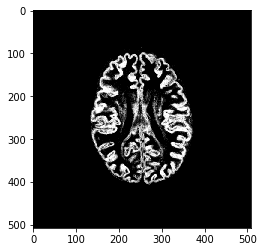

In [56]:
plt.imshow(gm,cmap='gray')

In [ ]:
misc.imsave("p5-7-7_gm.bmp",gm)

### (4) WM Prob

In [57]:
wm=c[:,1]
wm=wm.reshape((len(wm),1))
probwm=np.zeros((fullpatch.shape[0],1,1))
probwm[:,0,0]=fullpatch[:,0,0,0]
probwm[index,0,0]=wm[:,0]
wm=reconstruct_from_patches_2d(probwm,(height,height)) 

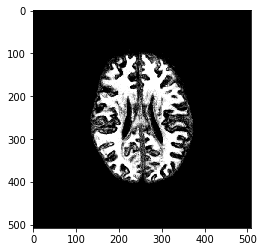

In [59]:
plt.imshow(wm,cmap='gray')

In [ ]:
misc.imsave("p5-7-7_wm.bmp",wm)

### (5) CSF Prob

In [64]:
csf=c[:,2]
csf=csf.reshape((len(csf),1))
probcsf=np.zeros((fullpatch.shape[0],1,1))
probcsf[:,0,0]=fullpatch[:,0,0,0]
probcsf[index,0,0]=csf[:,0]
csf=reconstruct_from_patches_2d(probcsf,(height,height)) 

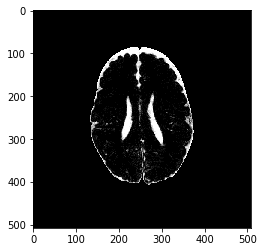

In [65]:
plt.imshow(csf,cmap='gray')

In [ ]:
misc.imsave("p19_csf.bmp",csf)